## Import Libraries

In [1]:
'''basics'''
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))
sys.setrecursionlimit(20500)
import pandas as pd
import pickle5 as pickle
import numpy as np

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB


'''Metrics/Evaluation'''
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')


## Import data and holdout data for prediction

In [2]:
df = pd.read_csv('../data/processed/encoded_labels/technical_area_2.csv')
df.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'technical_area_2',
       '_small_island_dev_states_program_sids',
       'chemicals_and_waste_programme', 'climate_change_adaptation_programme',
       'climate_forest_of_climate_change_mitigation',
       'climate_information_and_early_warning_systems_ci_ews',
       'climate_resilient_integrated_water_resource_coastal_area_management',
       'climate_strategies_and_policy_programme', 'cooling_alternatives',
       'cross_cutting_governance_and_learning',
       'cross_sectoral_climate_resilient_livelihoods',
       'ecosystem_based_adaptation', 'ecosystem_management_and_restoration',
       'energy_access', 'energy_efficiency',
       'energy_program_of_climate_change_mitigation',
       'environmental_governance_programme',
       'fostering_food_security_and_resilient_agricultural_systems',
       'heavy_metals', 'mainstreaming_biodiversity',
       'mainstreaming_integrated_policy_and_planning_for_climate_resilient_sus

In [3]:
df_labels = df.drop(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'technical_area_2'], axis=1)
counts = []
categories = list(df_labels.columns.values)
for i in categories:
    counts.append((i, df_labels[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_inputs'])
df_stats

,category,number_of_inputs
0,_small_island_dev_states_program_sids,1
1,chemicals_and_waste_programme,1
2,climate_change_adaptation_programme,20
3,climate_forest_of_climate_change_mitigation,2
4,climate_information_and_early_warning_systems_...,14
5,climate_resilient_integrated_water_resource_co...,14
6,climate_strategies_and_policy_programme,24
7,cooling_alternatives,3
8,cross_cutting_governance_and_learning,6
9,cross_sectoral_climate_resilient_livelihoods,10


Text(0.5, 0, 'category')

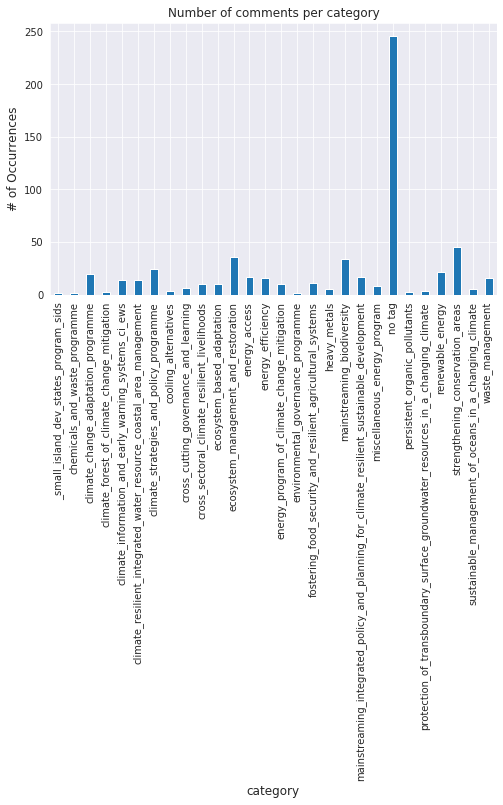

In [4]:
df_stats.plot(x='category', y='number_of_inputs', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

## How many comments have multi labels

Text(0.5, 0, '# of categories')

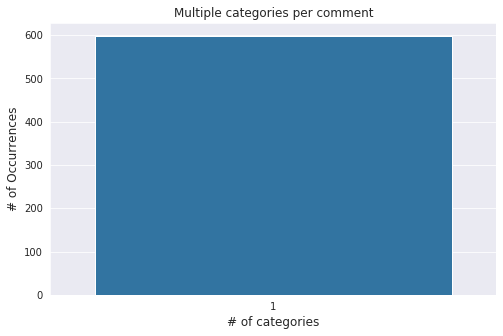

In [5]:
rowsums = df.iloc[:,4:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

## The distribution of the number of words in input texts

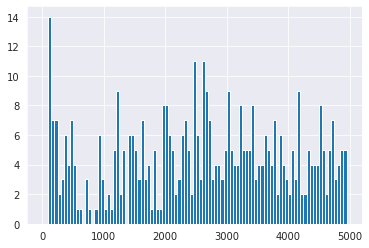

In [6]:
lens = df.all_text_clean.str.len()
lens.hist(bins = np.arange(0,5000,50))

## Holding out 5 rows from the original dataframe for prediction at the end

In [7]:
df_holdout = df.iloc[:5]

df = df.iloc[5:]

In [8]:
df.columns

Index(['PIMS_ID', 'all_text_clean', 'all_text_clean_spacy', 'technical_area_2',
       '_small_island_dev_states_program_sids',
       'chemicals_and_waste_programme', 'climate_change_adaptation_programme',
       'climate_forest_of_climate_change_mitigation',
       'climate_information_and_early_warning_systems_ci_ews',
       'climate_resilient_integrated_water_resource_coastal_area_management',
       'climate_strategies_and_policy_programme', 'cooling_alternatives',
       'cross_cutting_governance_and_learning',
       'cross_sectoral_climate_resilient_livelihoods',
       'ecosystem_based_adaptation', 'ecosystem_management_and_restoration',
       'energy_access', 'energy_efficiency',
       'energy_program_of_climate_change_mitigation',
       'environmental_governance_programme',
       'fostering_food_security_and_resilient_agricultural_systems',
       'heavy_metals', 'mainstreaming_biodiversity',
       'mainstreaming_integrated_policy_and_planning_for_climate_resilient_sus

##  Features engineering

In [9]:
categories = ['_small_island_dev_states_program_sids',
       'chemicals_and_waste_programme', 'climate_change_adaptation_programme',
       'climate_forest_of_climate_change_mitigation',
       'climate_information_and_early_warning_systems_ci_ews',
       'climate_resilient_integrated_water_resource_coastal_area_management',
       'climate_strategies_and_policy_programme', 'cooling_alternatives',
       'cross_cutting_governance_and_learning',
       'cross_sectoral_climate_resilient_livelihoods',
       'ecosystem_based_adaptation', 'ecosystem_management_and_restoration',
       'energy_access', 'energy_efficiency',
       'energy_program_of_climate_change_mitigation',
       'environmental_governance_programme',
       'fostering_food_security_and_resilient_agricultural_systems',
       'heavy_metals', 'mainstreaming_biodiversity',
       'mainstreaming_integrated_policy_and_planning_for_climate_resilient_sustainable_development',
       'miscellaneous_energy_program', 'no tag',
       'persistent_organic_pollutants',
       'protection_of_transboundary_surface_groundwater_resources_in_a_changing_climate',
       'renewable_energy', 'strengthening_conservation_areas',
       'sustainable_management_of_oceans_in_a_changing_climate',
       'waste_management']


#Creating the features (tf-idf weights) for the processed text
texts = df['all_text_clean'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts)

#Turning the labels into numbers
y = pd.DataFrame(df, columns = categories)
#Dimenionality reduction. Only using the 100 best features er category

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)


## Train multiple ML models / OneVsRest multi-label strategy

In [10]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
#Creating a dict of the models
model_dict = {
              'Stochastic Gradient Descent' : OneVsRestClassifier(SGDClassifier(random_state=3, loss='log'), n_jobs=1),
              'Random Forest': OneVsRestClassifier(RandomForestClassifier(random_state=3), n_jobs=1),
              'Decsision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=3), n_jobs=1),
              'AdaBoost': OneVsRestClassifier(AdaBoostClassifier(random_state=3), n_jobs=1),
              'Gaussian Naive Bayes': OneVsRestClassifier(GaussianNB(), n_jobs=1),
              'K Nearest Neighbor': OneVsRestClassifier(KNeighborsClassifier(), n_jobs=1)}


#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True,  
                                                    random_state = 3)
y_train = y_train.dropna(axis=1)
#Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df


def printTable(myDict, colList=None, sep='\uFFFA'):
    """ Pretty print a list of dictionaries (myDict) as a dynamically sized table.
   If column names (colList) aren't specified, they will show in random order.
   sep: row separator. Ex: sep='\n' on Linux. Default: dummy to not split line.
   Author: Thierry Husson - Use it as you want but don't blame me.
   """
    if not colList: colList = list(myDict[0].keys() if myDict else [])
    myList = [colList] # 1st row = header
    for item in myDict: myList.append([str(item[col] or '') for col in colList])
    colSize = [max(map(len,(sep.join(col)).split(sep))) for col in zip(*myList)]
    formatStr = ' | '.join(["{{:<{}}}".format(i) for i in colSize])
    line = formatStr.replace(' | ','-+-').format(*['-' * i for i in colSize])
    item=myList.pop(0); lineDone=False
    while myList:
        if all(not i for i in item):
            item=myList.pop(0)
            if line and (sep!='\uFFFA' or not lineDone): print(line); lineDone=True
        row = [i.split(sep,1) for i in item]
        print(formatStr.format(*[i[0] for i in row]))
        item = [i[1] if len(i)>1 else '' for i in row]
        

from tabulate import tabulate        
lis = []
for category in categories:
    dic = {}
    dff = model_score_df(model_dict, X_train, X_test, y_train[category], y_test[category])
    # Using DataFrame.insert() to add a column
    dic['Category'] = category
    dic['#Inputs'] = df_stats.number_of_inputs[df_stats['category'] == category]
    dic['Classifiers'] = '    \n '.join(dff.model_name.apply(str).tolist())
    dic['accuracy_score'] = '    \n '.join(dff.accuracy_score.apply(str).tolist()) 
    dic['precision_score'] = '   \n '.join(dff.precision_score.apply(str).tolist())
    dic['recall_score'] = '    \n '.join(dff.recall_score.apply(str).tolist())
    dic['f1_score'] = '    \n '.join(dff.f1_score.apply(str).tolist())
    lis.append(dic)
    
#headers = ['Category', 'Classifiers', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#print(tabulate(lis, tablefmt='html'))
header = lis[0].keys()
rows =  [x.values() for x in lis]
#print (tabulate(rows, header, tablefmt='html'))


<table>
<thead>
<tr><th>Category                                                                                  </th><th style="text-align: right;">  #Inputs</th><th>Classifiers  </th><th>accuracy_score  </th><th>precision_score  </th><th>recall_score  </th><th>f1_score  </th></tr>
</thead>
<tbody>
<tr><td>_small_island_dev_states_program_sids                                                     </td><td style="text-align: right;">        1</td><td>Random Forest    
 Decsision Tree    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 AdaBoost              </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.9943820224719101    
 0.9943820224719101                 </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 0.5   <br>
 0.5                  </td><td>1.0  <br>  
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.49719101123595505    
 0.49719101123595505               </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.49859154929577465    
 0.49859154929577465           </td></tr>
<tr><td>chemicals_and_waste_programme                                                             </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.9943820224719101                 </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 0.5                  </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.49719101123595505               </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.49859154929577465           </td></tr>
<tr><td>climate_change_adaptation_programme                                                       </td><td style="text-align: right;">       20</td><td>Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 AdaBoost    
 K Nearest Neighbor    
 Decsision Tree    
 Random Forest              </td><td>0.9831460674157303    
 0.9719101123595506    
 0.9719101123595506    
 0.9719101123595506    
 0.9662921348314607    
 0.9662921348314607                 </td><td>0.9911764705882353   
 0.9854651162790697   
 0.9854651162790697   
 0.9854651162790697   
 0.9139515455304928   
 0.9826589595375723                  </td><td>0.8636363636363636    
 0.7727272727272727    
 0.7727272727272727    
 0.7727272727272727    
 0.7697332607512248    
 0.7272727272727273               </td><td>0.9166015930032797    
 0.8455665452021517    
 0.8455665452021517    
 0.8455665452021517    
 0.8244575936883629    
 0.8036764705882353           </td></tr>
<tr><td>climate_forest_of_climate_change_mitigation                                               </td><td style="text-align: right;">        2</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>1.0 <br>    
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.9887640449438202                 </td><td>1.0  <br> 
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 0.5                  </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.4943820224719101               </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.4971751412429378           </td></tr>
<tr><td>climate_information_and_ <br> early_warning_systems_ci_ews                                      </td><td style="text-align: right;">       14</td><td>Decsision Tree    
 AdaBoost    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest              </td><td>0.9719101123595506    
 0.9775280898876404    
 0.9719101123595506    
 0.9606741573033708    
 0.9775280898876404    
 0.9719101123595506                 </td><td>0.7441860465116279   
 0.8247619047619048   
 0.7413793103448276   
 0.6579457364341085   
 0.9887005649717514   
 0.4859550561797753                  </td><td>0.7913294797687861    
 0.6971098265895954    
 0.6942196531791908    
 0.6884393063583816  <br>  
 0.6    <br>
 0.5               </td><td>0.7654808959156785    
 0.7442528735632183    
 0.7150176112712135    
 0.6716732542819499    
 0.660952380952381    
 0.4928774928774929           </td></tr>
<tr><td>climate_resilient_integrated_ <br> water_resource_coastal_area_management                       </td><td style="text-align: right;">       14</td><td>AdaBoost    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9831460674157303    
 0.9550561797752809    
 0.9775280898876404    
 0.9775280898876404    
 0.9775280898876404    
 0.9662921348314607                 </td><td>0.9915254237288136   
 0.6191176470588236   
 0.4887640449438202   
 0.4887640449438202   
 0.4887640449438202   
 0.48863636363636365                  </td><td>0.625    <br>
 0.7327586206896552   <br> 
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.4942528735632184               </td><td>0.6957264957264957    
 0.6550387596899224    
 0.4943181818181818    
 0.4943181818181818    
 0.4943181818181818    
 0.4914285714285714           </td></tr>
<tr><td>climate_strategies_and_policy_programme                                                   </td><td style="text-align: right;">       24</td><td>AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree    
 Stochastic Gradient Descent    
 Random Forest              </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 0.9887640449438202    
 0.9831460674157303    
 0.9831460674157303                 </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 0.9137596899224807   
 0.9914285714285714   
 0.9914285714285714                  </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 0.9137596899224807    <br>
 0.75    <br>
 0.75               </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 0.9137596899224807    
 0.8290105667627281    
 0.8290105667627281           </td></tr>
<tr><td>cooling_alternatives                                                                      </td><td style="text-align: right;">        3</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9943820224719101    
 0.9943820224719101    
 0.9943820224719101    
 0.9943820224719101    
 0.9943820224719101    
 0.9887640449438202                 </td><td>0.49719101123595505   
 0.49719101123595505   
 0.49719101123595505   
 0.49719101123595505   
 0.49719101123595505   
 0.4971751412429379                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.4971751412429379               </td><td>0.49859154929577465    
 0.49859154929577465    
 0.49859154929577465    
 0.49859154929577465    
 0.49859154929577465    
 0.4971751412429379           </td></tr>
<tr><td>cross_cutting_governance_and_learning                                                     </td><td style="text-align: right;">        6</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9887640449438202    
 0.9887640449438202    
 0.9887640449438202    
 0.9887640449438202    
 0.9887640449438202    
 0.9887640449438202                 </td><td>0.4943820224719101   
 0.4943820224719101   
 0.4943820224719101   
 0.4943820224719101   
 0.4943820224719101   
 0.4943820224719101                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5               </td><td>0.4971751412429378    
 0.4971751412429378    
 0.4971751412429378    
 0.4971751412429378    
 0.4971751412429378    
 0.4971751412429378           </td></tr>
<tr><td>cross_sectoral_climate_ <br> resilient_livelihoods                                              </td><td style="text-align: right;">       10</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9662921348314607    
 0.9662921348314607    
 0.9662921348314607    
 0.9662921348314607    
 0.9662921348314607    
 0.949438202247191                 </td><td>0.48314606741573035   
 0.48314606741573035   
 0.48314606741573035   
 0.48314606741573035   
 0.48314606741573035   
 0.4828571428571429                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.49127906976744184               </td><td>0.4914285714285714    
 0.4914285714285714    
 0.4914285714285714    
 0.4914285714285714    
 0.4914285714285714    
 0.48703170028818443           </td></tr>
<tr><td>ecosystem_based_adaptation                                                                </td><td style="text-align: right;">       10</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 K Nearest Neighbor    
 Decsision Tree    
 Gaussian Naive Bayes              </td><td>0.9887640449438202    
 0.9887640449438202    
 0.9887640449438202    
 0.9887640449438202    
 0.9775280898876404    
 0.9438202247191011                 </td><td>0.4943820224719101   
 0.4943820224719101   
 0.4943820224719101   
 0.4943820224719101   
 0.4943181818181818   
 0.49411764705882355                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.4943181818181818    
 0.4772727272727273               </td><td>0.4971751412429378    
 0.4971751412429378    
 0.4971751412429378    
 0.4971751412429378    
 0.4943181818181818    
 0.48554913294797686           </td></tr>
<tr><td>ecosystem_management_and_restoration                                                      </td><td style="text-align: right;">       36</td><td>Gaussian Naive Bayes    
 Decsision Tree    
 Random Forest    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 AdaBoost              </td><td>0.8539325842696629    
 0.9101123595505618    
 0.9382022471910112    
 0.9382022471910112    
 0.9213483146067416    
 0.9101123595505618                 </td><td>0.6294670846394984   
 0.612411540555253   
 0.4691011235955056   
 0.4691011235955056   
 0.4685714285714286   
 0.4682080924855491                  </td><td>0.8372346216657593    
 0.612411540555253    <br>
 0.5    <br>
 0.5    <br>
 0.49101796407185627    
 0.48502994011976047               </td><td>0.6628787878787878    
 0.612411540555253    
 0.4840579710144927    
 0.4840579710144927    
 0.4795321637426901    
 0.4764705882352941           </td></tr>
<tr><td>energy_access                                                                             </td><td style="text-align: right;">       17</td><td>Decsision Tree    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 Random Forest    
 K Nearest Neighbor    
 AdaBoost              </td><td>0.9662921348314607    
 0.8820224719101124    
 0.9775280898876404    
 0.9775280898876404    
 0.9662921348314607    
 0.9606741573033708                 </td><td>0.6163793103448276   
 0.5619915848527349   
 0.4887640449438202   
 0.4887640449438202   
 0.48863636363636365   
 0.48857142857142855                  </td><td>0.6163793103448276    
 0.8175287356321839   <br> 
 0.5    <br>
 0.5    <br>
 0.4942528735632184    
 0.49137931034482757               </td><td>0.6163793103448276    
 0.5791962174940898    
 0.4943181818181818    
 0.4943181818181818    
 0.4914285714285714    
 0.4899713467048711           </td></tr>
<tr><td>energy_efficiency                                                                         </td><td style="text-align: right;">       16</td><td>Stochastic Gradient Descent    
 Gaussian Naive Bayes    
 AdaBoost    
 Random Forest    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9719101123595506    
 0.9101123595505618    
 0.9719101123595506    
 0.9719101123595506    
 0.9606741573033708    
 0.9438202247191011                 </td><td>0.7441860465116279   
 0.6190476190476191   
 0.7386363636363636   
 0.4859550561797753   
 0.48579545454545453   
 0.48554913294797686                  </td><td>0.7913294797687861    
 0.953757225433526    
 0.5971098265895953    <br>
 0.5    <br>
 0.49421965317919075    
 0.48554913294797686               </td><td>0.7654808959156785    
 0.6680652680652681    
 0.6356938190749079    
 0.4928774928774929    
 0.489971346704871    
 0.48554913294797686           </td></tr>
<tr><td>energy_program_of_climate <br> _change_mitigation                                               </td><td style="text-align: right;">       10</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.9719101123595506                 </td><td>1.0  <br> 
 1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 0.5833333333333334                  </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.9858757062146892               </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.635693819074908           </td></tr>
<tr><td>environmental_governance_programme                                                        </td><td style="text-align: right;">        1</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9943820224719101    
 0.9943820224719101    
 0.9943820224719101    
 0.9943820224719101    
 0.9943820224719101    
 0.9943820224719101                 </td><td>0.49719101123595505   
 0.49719101123595505   
 0.49719101123595505   
 0.49719101123595505   
 0.49719101123595505   
 0.49719101123595505                  </td><td>0.5 <br>   
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5               </td><td>0.49859154929577465    
 0.49859154929577465    
 0.49859154929577465    
 0.49859154929577465    
 0.49859154929577465    
 0.49859154929577465           </td></tr>
<tr><td>fostering_food_security_and <br> _resilient_agricultural_systems                                </td><td style="text-align: right;">       11</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 K Nearest Neighbor    
 Decsision Tree    
 Gaussian Naive Bayes              </td><td>0.9719101123595506    
 0.9719101123595506    
 0.9719101123595506    
 0.9719101123595506    
 0.9662921348314607    
 0.9606741573033708                 </td><td>0.4859550561797753   
 0.4859550561797753   
 0.4859550561797753   
 0.4859550561797753   
 0.4858757062146893   
 0.48579545454545453                  </td><td>0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.49710982658959535    
 0.49421965317919075               </td><td>0.4928774928774929    
 0.4928774928774929    
 0.4928774928774929    
 0.4928774928774929    
 0.4914285714285714    
 0.489971346704871           </td></tr>
<tr><td>heavy_metals                                                                              </td><td style="text-align: right;">        5</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 K Nearest Neighbor    
 Decsision Tree    
 Gaussian Naive Bayes              </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.9943820224719101    
 0.9887640449438202                 </td><td>1.0   <br>
 1.0   <br>
 1.0   <br>
 1.0   <br>
 0.5  <br>
 0.5                </td><td>1.0   <br> 
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.49719101123595505    
 0.4943820224719101               </td><td>1.0    <br>
 1.0    <br>
 1.0    <br>
 1.0    <br>
 0.49859154929577465    
 0.4971751412429378           </td></tr>
<tr><td>mainstreaming_biodiversity                                                                </td><td style="text-align: right;">       34</td><td>Gaussian Naive Bayes    
 Random Forest    
 AdaBoost    
 Decsision Tree    
 K Nearest Neighbor    
 Stochastic Gradient Descent              </td><td>0.8426966292134831    
 0.9269662921348315    
 0.9157303370786517    
 0.8820224719101124    
 0.9213483146067416    
 0.9157303370786517                 </td><td>0.613063063063063   
 0.963276836158192   
 0.6295238095238095   
 0.5170940170940171   
 0.4606741573033708   
 0.4604519774011299                  </td><td>0.7186411149825784    
 0.5357142857142857    
 0.5296167247386759    
 0.5113240418118467   <br> 
 0.5    <br>
 0.4969512195121951               </td><td>0.6369463869463869    
 0.5476050830889541    
 0.536699635606455    
 0.5119467293380336    
 0.4795321637426901    
 0.47800586510263926           </td></tr>
<tr><td>mainstreaming_integrated_policy_ <br> and_planning_for_climate_ <br> resilient_sustainable_development</td><td style="text-align: right;">       17</td><td>Gaussian Naive Bayes    
 K Nearest Neighbor    
 Random Forest    
 Stochastic Gradient Descent    
 AdaBoost    
 Decsision Tree              </td><td>0.9157303370786517    
 0.9606741573033708    
 0.9831460674157303    
 0.9662921348314607    
 0.9606741573033708    
 0.9550561797752809                 </td><td>0.5833333333333334   
 0.5775193798449613   
 0.49157303370786515   
 0.49142857142857144   
 0.49137931034482757   
 0.4913294797687861                  </td><td>0.9571428571428571    
 0.6523809523809524  <br>  
 0.5    <br>
 0.49142857142857144    
 0.48857142857142855    
 0.4857142857142857               </td><td>0.6204690831556503    
 0.601024655779699    
 0.49575070821529743    
 0.49142857142857144    
 0.4899713467048711    
 0.48850574712643674           </td></tr>
<tr><td>miscellaneous_energy_program                                                              </td><td style="text-align: right;">        8</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9775280898876404    
 0.9775280898876404    
 0.9775280898876404    
 0.9775280898876404    
 0.9775280898876404    
 0.9606741573033708                 </td><td>0.4887640449438202   
 0.4887640449438202   
 0.4887640449438202   
 0.4887640449438202   
 0.4887640449438202   
 0.48857142857142855                  </td><td>0.5  <br>  
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.5    <br>
 0.49137931034482757               </td><td>0.4943181818181818    
 0.4943181818181818    
 0.4943181818181818    
 0.4943181818181818    
 0.4943181818181818    
 0.4899713467048711           </td></tr>
<tr><td>no tag                                                                                    </td><td style="text-align: right;">      246</td><td>Random Forest    
 Stochastic Gradient Descent    
 AdaBoost    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 Decsision Tree              </td><td>0.7921348314606742    
 0.7471910112359551    
 0.7303370786516854    
 0.7247191011235955    
 0.6797752808988764    
 0.6067415730337079                 </td><td>0.7641537324464154   
 0.723091976516634   
 0.7093653250773994   
 0.6900621118012422   
 0.6534246575342466   
 0.6009858442871587                  </td><td>0.7567528735632183    
 0.7456896551724138    
 0.7331896551724137    
 0.6978448275862069    
 0.6689655172413793    
 0.6147988505747126               </td><td>0.7601514985979095    
 0.7282442748091603    
 0.7127874142799515    
 0.6932653420080885    
 0.6557760814249364    
 0.591850104821803           </td></tr>
<tr><td>persistent_organic_pollutants                                                             </td><td style="text-align: right;">        2</td><td>Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Decsision Tree              </td><td>1.0    
 1.0    
 1.0    
 1.0    
 0.9943820224719101    
 0.9887640449438202                 </td><td>1.0   
 1.0   
 1.0   
 1.0   
 0.5   
 0.5                  </td><td>1.0    
 1.0    
 1.0    
 1.0    
 0.49719101123595505    
 0.4943820224719101               </td><td>1.0    
 1.0    
 1.0    
 1.0    
 0.49859154929577465    
 0.4971751412429378           </td></tr>
<tr><td>protection_of_transboundary_surface_groundwater_resources_in_a_changing_climate           </td><td style="text-align: right;">        3</td><td>Stochastic Gradient Descent    
 Random Forest    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor    
 Decsision Tree              </td><td>0.9943820224719101    
 0.9943820224719101    
 0.9943820224719101    
 0.9943820224719101    
 0.9943820224719101    
 0.9831460674157303                 </td><td>0.49719101123595505   
 0.49719101123595505   
 0.49719101123595505   
 0.49719101123595505   
 0.49719101123595505   
 0.4971590909090909                  </td><td>0.5    
 0.5    
 0.5    
 0.5    
 0.5    
 0.4943502824858757               </td><td>0.49859154929577465    
 0.49859154929577465    
 0.49859154929577465    
 0.49859154929577465    
 0.49859154929577465    
 0.49575070821529743           </td></tr>
<tr><td>renewable_energy                                                                          </td><td style="text-align: right;">       21</td><td>Stochastic Gradient Descent    
 K Nearest Neighbor    
 Gaussian Naive Bayes    
 AdaBoost    
 Decsision Tree    
 Random Forest              </td><td>0.9438202247191011    
 0.9438202247191011    
 0.8707865168539326    
 0.9325842696629213    
 0.9213483146067416    
 0.9438202247191011                 </td><td>0.7244318181818181   
 0.7244318181818181   
 0.5569347898047005   
 0.5991379310344828   
 0.5571705426356589   
 0.47191011235955055                  </td><td>0.5470238095238096    
 0.5470238095238096    
 0.6023809523809524    
 0.5410714285714285    
 0.5351190476190476    
 0.5               </td><td>0.5687984496124031    
 0.5687984496124031    
 0.5682800801434145    
 0.5538847117794486    
 0.5419117647058824    
 0.48554913294797686           </td></tr>
<tr><td>strengthening_conservation_areas                                                          </td><td style="text-align: right;">       45</td><td>AdaBoost    
 Gaussian Naive Bayes    
 Stochastic Gradient Descent    
 K Nearest Neighbor    
 Decsision Tree    
 Random Forest              </td><td>0.9382022471910112    
 0.8426966292134831    
 0.9325842696629213    
 0.9269662921348315    
 0.8876404494382022    
 0.9213483146067416                 </td><td>0.8308270676691729   
 0.6588768115942029   
 0.9659090909090908   
 0.799047619047619   
 0.524264705882353   
 0.4606741573033708                  </td><td>0.6724738675958188    
 0.8819686411149825    
 0.5714285714285714    
 0.5683797909407665    
 0.5143728222996515    
 0.5               </td><td>0.7216773276474769    
 0.6943831248467011    
 0.6073529411764707    
 0.5984730175255943    
 0.5155144256940665    
 0.4795321637426901           </td></tr>
<tr><td>sustainable_management_of_oceans_in_a_changing_climate                                    </td><td style="text-align: right;">        5</td><td>Stochastic Gradient Descent    
 Random Forest    
 Decsision Tree    
 AdaBoost    
 Gaussian Naive Bayes    
 K Nearest Neighbor              </td><td>0.9831460674157303    
 0.9831460674157303    
 0.9831460674157303    
 0.9831460674157303    
 0.9831460674157303    
 0.9831460674157303                 </td><td>0.49157303370786515   
 0.49157303370786515   
 0.49157303370786515   
 0.49157303370786515   
 0.49157303370786515   
 0.49157303370786515                  </td><td>0.5    
 0.5    
 0.5    
 0.5    
 0.5    
 0.5               </td><td>0.49575070821529743    
 0.49575070821529743    
 0.49575070821529743    
 0.49575070821529743    
 0.49575070821529743    
 0.49575070821529743           </td></tr>
<tr><td>waste_management                                                                          </td><td style="text-align: right;">       16</td><td>Gaussian Naive Bayes    
 AdaBoost    
 Decsision Tree    
 K Nearest Neighbor    
 Stochastic Gradient Descent    
 Random Forest              </td><td>0.9831460674157303    
 0.9719101123595506    
 0.9662921348314607    
 0.9606741573033708    
 0.9662921348314607    
 0.9606741573033708                 </td><td>0.8720588235294118   
 0.8635057471264368   
 0.819047619047619   
 0.735632183908046   
 0.9830508474576272   
 0.7329545454545454                  </td><td>0.9227234753550543    
 0.7113617376775271    
 0.6399331662489557    
 0.6370091896407686    
 0.5714285714285714    
 0.5685045948203843               </td><td>0.8956011730205278    
 0.7654808959156785    
 0.6913294797687861    
 0.6716732542819499    
 0.6163793103448276    
 0.601024655779699           </td></tr>
</tbody>
</table>